Some Basic Imports

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

Sample on how to read the csv

In [3]:
df = pd.read_csv("azure/postgres/tpcc/traditional_run_0.csv")
# required to convert to json file format used in the scripts
df["Config"] = df["Config"].apply(eval)
df

,Unnamed: 0,Suggestion,Config,Worker,Performance
0,0,0,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",0,869.336182
1,1,1,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",0,247.664490
2,2,2,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",0,0.000000
3,3,3,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",0,0.000000
4,4,4,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",0,269.126343
5,5,5,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",0,996.115295
6,6,6,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",0,0.000000
7,7,7,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",0,0.000000
8,8,8,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",0,0.000000
9,9,9,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",0,815.888550


Plot the convergence curve

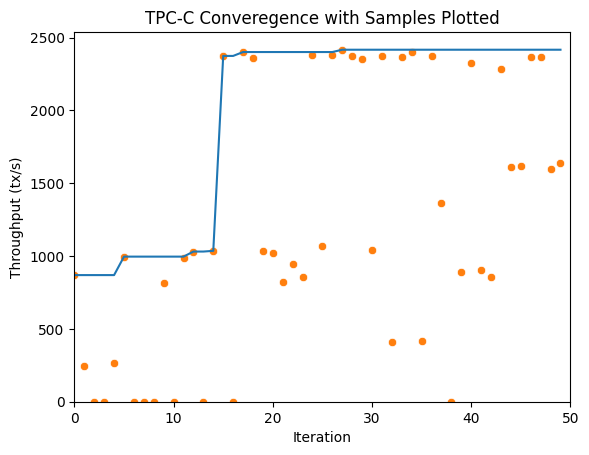

In [4]:
df["Best"] = df["Performance"].cummax()
line = sns.lineplot(data=df, x="Suggestion", y="Best")
scatter = sns.scatterplot(
    data=df, x="Suggestion",
    y="Performance",
    color="tab:orange"
).set(ylim=0, xlim=(0, 50), title="TPC-C Converegence with Samples Plotted", ylabel="Throughput (tx/s)", xlabel = "Iteration")


Helper function to compute relative range of set of configurations

In [36]:
def compute_relative_range(config):
    perf = config["Performance"]
    if np.mean(perf) == 0:
        return np.inf
    return (np.max(perf) - np.min(perf)) / np.mean(perf)

Select highest observed performance configuration for a workload

Note that this configuration is likely unstable

In [34]:
all_tpcc = pd.concat([pd.read_csv(file) for file in glob.glob("azure/postgres/tpcc/*.csv")]).reset_index(drop=True)
all_tpcc.loc[all_tpcc["Performance"].idxmax()][["Config", "Performance"]]

Config         {'autovacuum': 'off', 'autovacuum_analyze_scal...
Performance                                          3686.023926
Name: 5274, dtype: object

Select the lowest variability config (in terms of relative range). We will only select from max budget tuning runs from TUNA.

Note that this does not imply a well performing configuration

In [51]:
all_tpcc_TUNA = pd.concat([pd.read_csv(file) for file in glob.glob("azure/postgres/tpcc/TUNA*.csv")]).reset_index(drop=True)
groups = all_tpcc_TUNA.groupby("Config")
configs = [g[1] for g in groups if len(g[1]) == 10]

lowest_variance_config = min(configs, key=compute_relative_range)
lowest_variance_config

,Unnamed: 0,Suggestion,Config,Worker,Performance
2589,44,35,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",0,249.303207
2611,66,47,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",6,251.804214
2612,67,47,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",7,251.656448
2636,91,52,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",9,250.850586
2637,92,52,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",4,250.987000
2638,93,52,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",2,253.146286
2639,94,52,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",3,251.574844
2640,95,52,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",1,249.050079
2641,96,52,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",8,249.136398
2642,97,52,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",5,248.535095


Finding the configuration which has the best, worst case performance, with a relative range below 30%

In [65]:
stable_configs = [c for c in configs if compute_relative_range(c) < 0.3]
best_worst_case = max(stable_configs, key=lambda conf: conf["Performance"].min())
best_worst_case

,Unnamed: 0,Suggestion,Config,Worker,Performance
4483,411,246,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",4,3087.833984
4504,432,257,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",8,2840.801270
4505,433,257,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",1,2829.262451
4524,452,269,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",6,3182.392090
4525,453,269,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",5,2391.710938
4526,454,269,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",2,3194.722900
4527,455,269,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",3,3110.769775
4528,456,269,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",7,3204.592529
4529,457,269,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",0,3025.354492
4530,458,269,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",9,2833.675049


Note that the above configuration still experiences nearly a 30% degradation. We can tighten this to 10% and find more durable configs.

In [66]:
stable_configs = [c for c in configs if compute_relative_range(c) < 0.1]
best_worst_case = max(stable_configs, key=lambda conf: conf["Performance"].min())
best_worst_case

,Unnamed: 0,Suggestion,Config,Worker,Performance
3475,421,247,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",4,2387.611816
3500,446,266,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",5,2362.326416
3501,447,266,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",7,2359.299561
3521,467,281,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",2,2332.079346
3522,468,281,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",6,2393.009521
3523,469,281,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",0,2413.331543
3524,470,281,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",1,2384.849854
3525,471,281,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",9,2446.494873
3526,472,281,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",8,2351.651123
3527,473,281,"{'autovacuum': 'on', 'autovacuum_analyze_scale...",3,2330.636475


We can tighten this even further to 2% for some sacrificed performance

In [68]:
stable_configs = [c for c in configs if compute_relative_range(c) < 0.02]
best_worst_case = max(stable_configs, key=lambda conf: conf["Performance"].min())
best_worst_case

,Unnamed: 0,Suggestion,Config,Worker,Performance
3737,174,102,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",0,2130.564453
3760,197,122,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",9,2159.632080
3761,198,122,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",3,2118.807129
3782,219,135,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",6,2148.632324
3783,220,135,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",5,2161.130615
3784,221,135,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",7,2118.524414
3785,222,135,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",4,2136.113037
3786,223,135,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",1,2128.857910
3787,224,135,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",8,2130.029297
3788,225,135,"{'autovacuum': 'off', 'autovacuum_analyze_scal...",2,2143.894775
